# Community Analysis through Toxic Comment Identification

In this project we aim to:
* Identify toxic comments with high accuracy
* Explore ensemble and tensorflow models
* Prepare the final model for production use  
* Have fun!

The data that we'll be training with was provided by YouTube from [a Kaggle competition they ran in 2018](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data).

We'll be performing Term Frequency-Inverse Document Frequency analysis on the comments to train our models with. This will represent the comments in a numerical fashion that can be easily and meaningfully understood by the models.

In [0]:
import pandas as pd
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek
from keras.utils import to_categorical
from sklearn.preprocessing import normalize
from sklearn import neighbors, ensemble, tree,preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, RandomizedSearchCV

import warnings 
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [4]:
#import test.csv
toxic = pd.read_csv('train.csv')

toxic.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Looks like there's a few different varieties of toxicity for these comments, where 1 indicates toxic. Let's focus on a boolean of toxic or not, disreguarding subtype. For this we'll need to create a few features:

In [5]:
#feature engineering
#total_toxic which is the sum of all toxic subtypes
#a comment can have a max value of 6 if it were all tyoes of toxic
toxic['toxic_total'] = (toxic['toxic'] + toxic['severe_toxic'] +
                        toxic['obscene'] + toxic['threat'] + 
                        toxic['insult'] + toxic['identity_hate'])

#we're interested in a boolean measure of toxicity so any value over 0 becomes 1
toxic['toxic_bool'] = np.where(toxic['toxic_total']>0,1,0)

toxic.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_total,toxic_bool
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0


In [6]:
toxic['toxic_bool'].value_counts()

0    143346
1     16225
Name: toxic_bool, dtype: int64

So we see ~10% representation of toxic comments, that's a pretty harsh disparity and we'll address that inequality later to better feed our model. If we left it as is then the model could just predict "non-toxic" for all comments and be correct about 90% of the time.


Let's take a look at some statistics for comments that we'll be training with!

In [7]:
lens = toxic.comment_text.str.len()
print(f'Average Comment Length: {round(lens.mean())}\nStandard Deviation: {round(lens.std())}\nMax Comment Length: {round(lens.max())}')

Average Comment Length: 394
Standard Deviation: 591
Max Comment Length: 5000


Great! Now let's take a look at the distribution of word count:

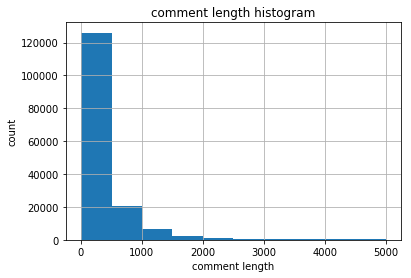

In [23]:
lens.hist()
plt.title('comment length histogram')
plt.xlabel('comment length')
plt.ylabel('count')
plt.savefig('comment_hist.png')

Alright, we see a strong right skewed distribution, as we might expect, but at least one person wrote a wopping 5000 word comment!

Let's being to prepare out model for TF-IDF analysis! We'll start with a train/test split:

In [0]:
# Define the features and the outcome.
X = toxic['comment_text']
y = toxic['toxic_bool']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=y)

Next we'll vectorize, reshape, perform TF-IDF,  and normalize  X

In [10]:
start_time = time.time()


vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
toxic_tfidf_train = vectorizer.fit_transform(X_train)
toxic_tfidf_test = vectorizer.transform(X_test)
print("vectorizer complete")

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = toxic_tfidf_train.tocsr()
X_test_tfidf_csr = toxic_tfidf_test.tocsr()
print('tocsr complete')

#number of sentences
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per sentence
tfidf_bysent = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]
print('tf-idf complete')
    
# Normalize the data.
X_train_norm = normalize(X_train_tfidf_csr)
X_test_norm = normalize(X_test_tfidf_csr)
print('normalization complete')

t= round((time.time() - start_time),4)
print("\n -- %s seconds for results--" % t)

vectorizer complete
tocsr complete
tf-idf complete
normalization complete

 -- 49.1252 seconds for results--


In [0]:
y_train.shape

(119678,)

In [0]:
#pickle.dump(vectorizer,open('tf_idf_vectorize.sav','wb'))
#vectorizer = pickle.load(open('tf_idf_vectorize.sav','rb'))

In [0]:
#X_train_vec = vectorizer.transform(X_train)
#X_test_vec = vectorizer.transform(X_test)

Next we'll address the class imbalance that we noticed earlier. by the end of it, we'll have equal counts non-toxic and toxic to train on. This will provide a better base for training and reduce bias.

In [0]:
start_time = time.time()

smt = SMOTETomek(random_state=42)
#class balancing
#only perform on the training set, this reduces bias in fitting the model.
X_res, y_res = smt.fit_resample(X_train_norm, y_train)

t= round((time.time() - start_time),4)
print("\n -- %s seconds for results--" % t)


 -- 1100.5114 seconds for results--


In [0]:
#save transformed and class-balanced training set
# file1 = open('X_train_final.pickle','wb')
# pickle.dump(X_res,file1)
# file1.close()
# file2 = open('y_train_pre.pickle','wb')
# pickle.dump(y_res,file2)
# file2.close()

In [0]:
#open saved inputs to save time
file3 = open('X_train_final.pickle','rb')
X_train_final = pickle.load(file3)
file3.close()

file4 = open('y_train_pre.pickle','rb')
y_train_pre = pickle.load(file4)
file4.close()


In [13]:
#confirm equal distribution
print(f'Length of y_train_pre: {len(y_train_pre)}')
print(f'Measure of distribution of y_train_pre: {y_train_pre.mean()}')

Length of y_train_pre: 214990
Measure of distribution of y_train_pre: 0.5


In [0]:
X_train_final.shape

(214990, 44454)

In [0]:
split = StratifiedShuffleSplit(n_splits=3, random_state=1337)

In [0]:
# Spot Check Algorithms
start_time = time.time()
models = []
models.append(('RFC', ensemble.RandomForestClassifier()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('DTC', tree.DecisionTreeClassifier()))
models.append(('GBC', ensemble.GradientBoostingClassifier()))
models.append(('ABC', ensemble.AdaBoostClassifier()))
models.append(('ETC', ensemble.ExtraTreesClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    split = StratifiedShuffleSplit(n_splits=3, random_state=1337)
    model = model.fit(X_train_final,y_train_pre)
    cv_results = cross_val_score(model, X_test_norm, y_test, cv=split, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
t= round((time.time() - start_time),4)
print("\n -- %s seconds for results--" % t) #22min

RFC: 0.951211 (0.002019)
KNN: 0.905597 (0.002282)
DTC: 0.941353 (0.003790)
GBC: 0.939683 (0.001764)
ABC: 0.947368 (0.002865)
ETC: 0.952381 (0.002813)

 -- 1319.1425 seconds for results--


Wow, great! each of the models performed quite well but ExtraTreesClassifier just barely edges out RandomForestClassifier as the top performer without any hyper praramter tuning.

In [0]:
start_time = time.time()

ETC = ensemble.ExtraTreesClassifier()
ETC.fit(X_train_final,y_train_pre)
cv_results = cross_val_score(ETC, 
                             X_test_norm, 
                             y_test, 
                             cv=split,
                             scoring='accuracy')


print(f'ETC test score: {cv_results.mean()}, STD: {cv_results.std()}')

t= round((time.time() - start_time),4)
print("\n -- %s seconds for results--" % t)

ETC test score: 0.9543024227234754, STD: 0.00031258624785076005

 -- 255.4806 seconds for results--


In [0]:
#pickle the ExtraTreesClassifier to get it production ready
file = open('toxic_ETC.sav','wb')
pickle.dump(ETC,file)
file.close()

Great, we have a well-performing model and we've saved it for production use. Let's compare it's performance to a Tensorflow/Keras model!

In [14]:
# Convert y to categorical to make compatible with keras model
y_train_final = to_categorical(y_train_pre)
y_test_final = to_categorical(y_test)
print('to_categorical complete')

to_categorical complete


In [0]:
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model

In [16]:
# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(100, activation='relu', input_dim= X_train_final.shape[1] ))

# Add a hidden layer 
model.add(Dense(100, activation='relu'))

# Add a hidden layer 
model.add(Dense(100, activation='relu'))

# Add an output layer 
model.add(Dense(2, activation='softmax'))

model.summary()

W0725 03:10:49.708691 139674263910272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 03:10:49.748089 139674263910272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 03:10:49.756081 139674263910272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               4445500   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 4,465,902
Trainable params: 4,465,902
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(X_train_final, y_train_final, epochs=3, batch_size=512, verbose=1, validation_data=(X_test_norm, y_test_final))
score = model.evaluate(X_test_norm, y_test_final, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

W0725 03:11:10.542508 139674263910272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 03:11:10.579689 139674263910272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0725 03:11:10.695898 139674263910272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0725 03:11:10.751858 139674263910272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated

Train on 214990 samples, validate on 39893 samples
Epoch 1/3
214990/214990 [==============================] - 59s 274us/step - loss: 0.1523 - acc: 0.9474 - val_loss: 0.2111 - val_acc: 0.9491
Epoch 2/3
214990/214990 [==============================] - 54s 253us/step - loss: 0.0194 - acc: 0.9946 - val_loss: 0.2536 - val_acc: 0.9500
Epoch 3/3
214990/214990 [==============================] - 54s 253us/step - loss: 0.0071 - acc: 0.9982 - val_loss: 0.2810 - val_acc: 0.9514
Test loss: 0.2809800424388192
Test accuracy: 0.9514200486360619


Great, using 'relu' activation yielded some pretty great results. I tested out numerous combinations of other activation functions but none yielded better results, measuring 0.93 and lower.

In [0]:
file = open('tensorflow.sav','wb')
pickle.dump(model,file)
file.close()

Now we pickle the trained model to use to predict whether or not a comment is toxic. Then we'll average the result for each comment across the videos of a channel to get an overall representation of the toxicity of the community.

# Conclusion

The ensemble method ExtraTreesClassifier and a Mean-Squared Error Tensorflow/Keras model performed quite well but ultimately the ensemble model ExtraTreesClassifier just barely performed the better so we'll go ahead and use a pickled version of that model going forward to analyze the youtube comments that we'll collect. 

## Obstacles
I thought that my biggest problem in this project would be the size of the data but it actually was determining the appropriate order of each step to get it to. I'm sure it seems obvious now in hindsight.

Another obstacle we encountered was significantly poorer performance of the model before class balancing was performed on the toxic boolean feature, where the minority represented only about 10% of the total inputs.

## The Future
One of the drawbacks with working with something that has such varied user input is that eventually the corpus will be a little out of date, missing relevant terms (i.e. slang, etc) that will come into use. Of course, a large amount of the provided corpus will remain relevant so overall model performance shouldn't dip too significantly. But when the day comes to re-fit the model, it could be quite taxing to label a brand new set of a few hundred thousand comments as various kinds of toxic.

## Applying the model to a non-training dataset
Please select the file titled "Application of Toxic-Community Model" to see the applicaiton of the model generated in this project